In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

from PIL import Image
import numpy as np

import torch
from torchvision import transforms

from diffusers import StableDiffusionInpaintPipeline
from transformers import CLIPTextModel, CLIPTokenizer

In [2]:
model_path = './ned-v1-22-inpainting-A62B4AC3A2.safetensors'
tokenizer_path = './input/model/clip/txt_emb_tokenizer'
text_model_path = './input/model/clip/txt_emb_model'

# stable diffusion inpainting

In [3]:
tokenizer = CLIPTokenizer.from_pretrained(tokenizer_path, local_files_only=True)
text_encoder = CLIPTextModel.from_pretrained(text_model_path, local_files_only=True).cuda().eval()

In [5]:
pipe =  StableDiffusionInpaintPipeline.from_single_file(
    pretrained_model_link_or_path=model_path,
    config_files={'v1': '../task/configs/v1-inference.yaml'},
    text_encoder=text_encoder,
    tokenizer=tokenizer,
    local_files_only=True, use_safetensors=True, load_safety_checker=False
).to("cuda")

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_inpaint.StableDiffusionInpaintPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


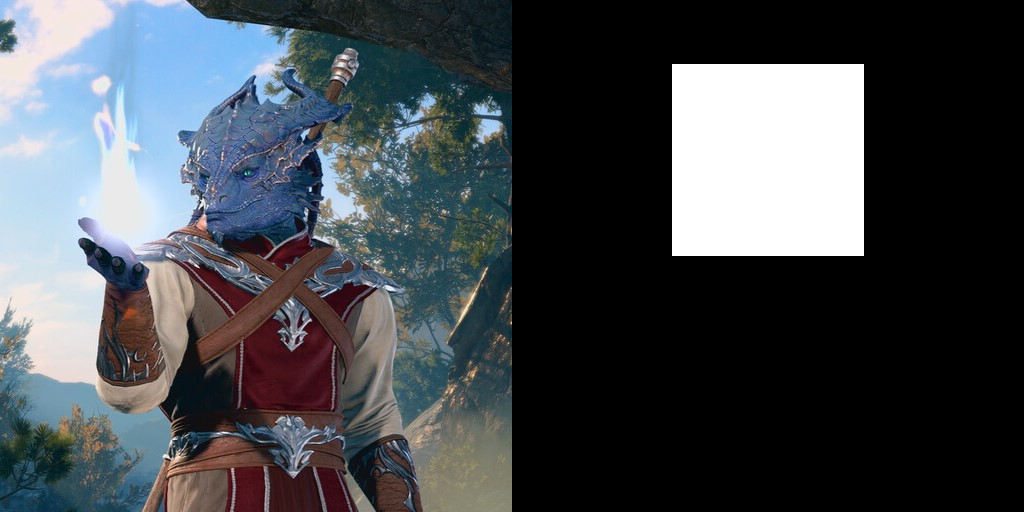

In [6]:
prompt = 'a handsome man with ray-ban sunglasses'

init_image = Image.open('./demo.jpg').convert("RGB").resize((512, 512))

mask = np.zeros((512, 512))
mask[64:256, 160:352] = 1
# mask[192:320, 192:320] = 1
mask = Image.fromarray(mask > 0).convert("RGB").resize((512, 512))

Image.fromarray(np.concatenate([np.array(init_image), np.array(mask)], axis=1))

  0%|          | 0/30 [00:00<?, ?it/s]

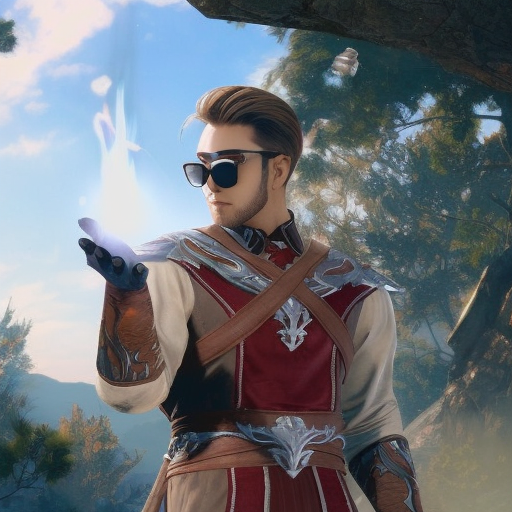

In [7]:
with torch.no_grad():
    image = pipe(
        prompt=prompt, image=init_image, mask_image=mask, num_inference_steps=40, strength=0.75, guidance_scale=7.5
    )
image.images[0]